In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr, spearmanr
from matplotlib.patches import Patch
import numpy as np

In [2]:
degs_all = pickle.load(open('../../results/degs_all.pkl', 'rb'))
exclude_genes = ['GARS', 'WDR61', 'C12orf45', 'INTS2', 'POLR2B', 'ZNF720', 'PRELID3B', 'C5orf30', 'SPATA5L1']
def read_metric(path, dataset, method):
    with open(path, 'rb') as f:
        dict_split = pickle.load(f)
        split = {}
        for k, v in dict_split.items():
            # get perturbation condition key
            if any(gene in k for gene in exclude_genes):
                continue
            true, pred, ctrl, _ = v.values()
            if method == 'biolord':
                pert_key = k.split('_')[1]
            elif method == 'gears':
                if dataset == 'adamson':
                    pert_key = f'{k}+ctrl'
                else:
                    pert_key = k
            if dataset == 'norman':
                pert_key = '+'.join(sorted(pert_key.split('+')))
            
            # compute metrics
            de_idx = degs_all[dataset][pert_key]
            true = true[de_idx]
            pred = pred[de_idx]
            ctrl = ctrl[de_idx]
            mse_k = mse(true, pred)/mse(true, ctrl)
            pear_k = pearsonr(true-ctrl, pred-ctrl)[0]
            spear_k = spearmanr(true, pred)[0]
            split[k] = {'NormMSE':mse_k, 'Pearson':pear_k, 'Spearman':spear_k}
        split = pd.DataFrame.from_dict(split, orient='index')
    return split

In [3]:
all_metrics = []
for dataset in ['dixit', 'adamson', 'k562', 'rpe1']: 
    biolord_og = []
    biolord_embd = []
    gears_og = []
    gears_embd = []
    type = 'unseen_single'
    n_split = 5 if dataset != 'dixit' else 10
    
    for i in range(1, n_split+1):
        biolord_og.append(read_metric(f"../extra/ReplaceInput/results/biolord_og/{dataset}_{i}.pkl", dataset, 'biolord').assign(split=i))
        biolord_embd.append(read_metric(f"../extra/ReplaceInput/results/biolord_embd/{dataset}_{i}.pkl", dataset, 'biolord').assign(split=i))
        gears_og.append(read_metric(f"../extra/ReplaceInput/results/gears_og/{dataset}_{type}_{i}.pkl", dataset, 'gears').assign(split=i))
        gears_embd.append(read_metric(f"../extra/ReplaceInput/results/gears_embd/{dataset}_{type}_{i}.pkl", dataset, 'gears').assign(split=i))

    biolord_og = pd.concat(biolord_og).assign(Method='Biolord', Embedding='GO')
    biolord_embd = pd.concat(biolord_embd).assign(Method='Biolord', Embedding='Embedding')
    gears_og = pd.concat(gears_og).assign(Method='Gears', Embedding='GO')
    gears_embd = pd.concat(gears_embd).assign(Method='Gears', Embedding='Embedding')

    metric_ds = pd.concat([biolord_og, biolord_embd, gears_og, gears_embd])
    metric_ds = metric_ds.groupby(['Method', 'Embedding'])[['NormMSE', 'Pearson']].median().reset_index().assign(dataset=dataset)
    all_metrics.append(metric_ds)

all_metrics = pd.concat(all_metrics)
all_metrics['dataset'] = all_metrics['dataset'].replace({
    'dixit': 'Dixit',
    'adamson': 'Adamson', 
    'k562': 'Replogle K562',
    'rpe1': 'Replogle RPE1'
})
all_metrics.drop(columns=['Pearson'], inplace=True)
all_pivot = all_metrics.pivot(index='dataset', columns=['Method', 'Embedding'], values='NormMSE')
all_pivot.loc['Dixit', ('Biolord', 'Embedding')] = None
all_pivot.loc['Dixit', ('Biolord', 'GO')] = None

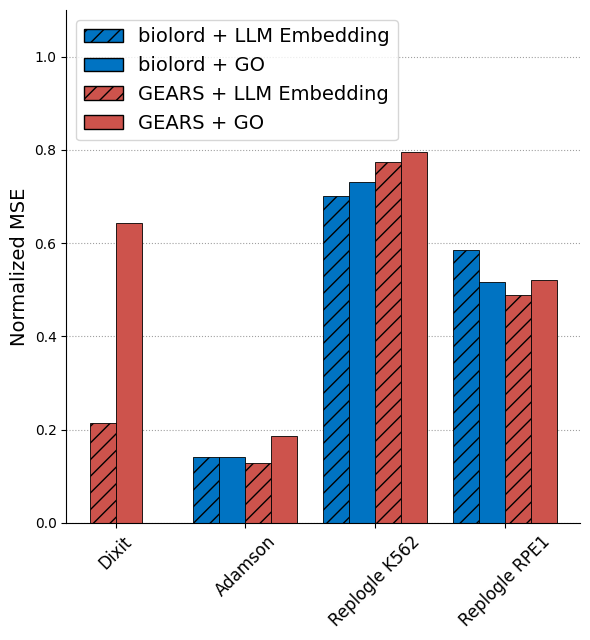

In [4]:
datasets = ['Dixit', 'Adamson', 'Replogle K562', 'Replogle RPE1']
methods = [('Biolord', 'Embedding'), ('Biolord', 'GO'), ('Gears', 'Embedding'), ('Gears', 'GO')]
colors = ['#0073C2FF', '#0073C2FF', '#CD534CFF', '#CD534CFF']
hatches = ['//', None, '//', None]

bar_width = 0.2
x = np.arange(len(datasets))
fig, ax = plt.subplots(figsize=(6, 6.5))
for i, (method, submethod) in enumerate(methods):
    offsets = []
    heights = []

    for j, dataset in enumerate(datasets):
        value = all_pivot.loc[dataset].get((method, submethod))
        if pd.notna(value):
            heights.append(value)
        else:
            heights.append(None)

    for j, height in enumerate(heights):
        if height is None:
            continue
        
        available_bars = [pd.notna(all_pivot.loc[datasets[j]].get(m)) for m in methods]
        total_bars = sum(available_bars)
        bar_index = sum([pd.notna(all_pivot.loc[datasets[j]].get(methods[k])) for k in range(i)])

        offset = (bar_index - total_bars / 2 + 0.5) * bar_width
        ax.bar(x[j] + offset, height, width=bar_width, color=colors[i],
               edgecolor='black', linewidth=0.6, hatch=hatches[i], zorder=2)

ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='center', fontsize=12)
plt.ylabel("Normalized MSE", fontsize=14)
plt.ylim(0, 1.1)
plt.title("", fontsize=14)
plt.grid(axis='y', linestyle=':', color='gray', alpha=0.75, zorder=0)
legend_elements = [
    Patch(facecolor='#0073C2FF', edgecolor='black', hatch='//', label='biolord + LLM Embedding'),
    Patch(facecolor='#0073C2FF', edgecolor='black', hatch=None, label='biolord + GO'),
    Patch(facecolor='#CD534CFF', edgecolor='black', hatch='//', label='GEARS + LLM Embedding'),
    Patch(facecolor='#CD534CFF', edgecolor='black', hatch=None, label='GEARS + GO'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()